## Description

The objective of this project is to test different architectures to compare two digits visible in a two-channel image. It aims at showing in particular the impact of weight sharing, and of the use of an auxiliary loss to help the training of the main objective. 
It should be implemented with PyTorch only code, in particular without using other external libraries such as scikit-learn or numpy.

The goal of this project is to implement a deep network such that, given as input a series of 2 ×14×14
tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is
lesser or equal to the second.

In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from dlc_practical_prologue import generate_pair_sets

## Data

The training and test set should be 1, 000 pairs each, and the size of the images allows to run
experiments rapidly, even in the VM with a single core and no GPU.
You can generate the data sets to use with the function generate_pair_sets(N) defined in the file
dlc_practical_prologue.py.

In [2]:
N = 1000

In [3]:
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(N)

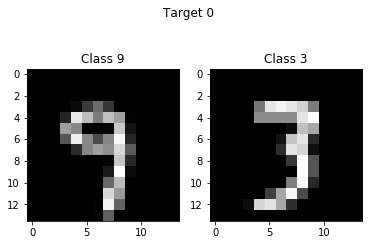

In [4]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(train_input[0][0], cmap="gray")
axs[0].set_title(f"Class {train_classes[0][0].item()}")
axs[1].imshow(train_input[0][1], cmap="gray")
axs[1].set_title(f"Class {train_classes[0][1].item()}")
fig.suptitle(f"Target {train_target[0].item()}")

plt.show()

In [5]:
train_loader = DataLoader(list(zip(train_input, train_target, train_classes)), batch_size=64)
test_loader = DataLoader(list(zip(test_input, test_target, test_classes)), batch_size=64)

## Objective

The goal of the project is to compare different architectures, and assess the performance improvement
that can be achieved through weight sharing, or using auxiliary losses. For the latter, the training can
in particular take advantage of the availability of the classes of the two digits in each pair, beside the
Boolean value truly of interest.

In [6]:
cross_entropy = nn.CrossEntropyLoss()
binary_cross_entropy = nn.BCELoss()

## Model

In [7]:
nb_channels = 2
nb_digits = 10
nb_class = 2

### Simple model

First let's implement simple model

In [8]:
class SimpleNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 2 * 2, 50)
        self.fc2 = nn.Linear(50, output_channels)
        
        self.predicts_digit=False

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def predict(self, x):
        output_class = self.forward(x)
        _, predicted_class = torch.max(output_class, 1)
        return predicted_class

In [9]:
net = SimpleNet(nb_channels, nb_class)

In [10]:
# def simple_model_criterion(output, target, digit, digit_target):
#     return cross_entropy(output, target)

In [11]:
from torchsummary import summary
summary(net, input_size=(2, 14, 14), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 12, 12]             114
         MaxPool2d-2              [-1, 6, 6, 6]               0
            Conv2d-3             [-1, 16, 4, 4]             880
         MaxPool2d-4             [-1, 16, 2, 2]               0
            Linear-5                   [-1, 50]           3,250
            Linear-6                    [-1, 2]             102
Total params: 4,346
Trainable params: 4,346
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


### Model with weight sharing

### Model with auxiliary loss

## Training

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
def get_accuracy(model, data_loader, calculate_accuracy_digit=False):
    if calculate_accuracy_digit:
        return get_accuracy_class_and_digit(model, data_loader)
    else:
        return get_accuracy_class(model, data_loader)
    
def get_accuracy_class_and_digit(model, data_loader):
    correct = 0
    correct_digit = 0
    total = 0
    
    for (image, target, digit_target) in data_loader:
        predicted, predicted_digit = model.predict(image)
        correct_digit += (predicted_digit == digit_target)
        total += len(target)
        
    accuracy = correct / total
    accuracy_digit = correct_digit / total
    return accuracy, accuracy_digit


def get_accuracy_class(model, data_loader):
    correct = 0
    total = 0
    
    for (image, target, digit_target) in data_loader:
        predicted = model.predict(image)
        correct += (predicted == target).sum().item()
        total += len(target)
        
    accuracy = correct / total
    return accuracy

In [14]:
def train(train_data_loader, test_data_loader,
          model, optimizer, criterion,
          epochs=10, test_every=10):
    
    losses = []
    accuracy_train = []
    accuracy_test = []
    accuracy_train_digit = []
    accuracy_test_digit = []
    
    for epoch in range(epochs):
        step = 0
        
        for (image, target, digit_target) in train_data_loader:
            step += 1

            optimizer.zero_grad()
            if model.predicts_digit:
                output, digit = model(image)
                loss = criterion(output, target, digit, digit_target)
            else:
                output = model(image)
                loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            if step % test_every == 0:
                losses.append(loss)
                
                model.eval()
                with torch.no_grad():
                    accuracy_train_data = get_accuracy(model, train_data_loader,
                                                       calculate_accuracy_digit=model.predicts_digit)
                    accuracy_test_data = get_accuracy(model, test_data_loader,
                                                      calculate_accuracy_digit=model.predicts_digit)
                    
                    if model.predicts_digit:
                        acc_train, acc_train_digit = accuracy_train_data
                        acc_test, acc_test_digit = accuracy_test_data
                        
                        accuracy_train_digit.append(acc_train_digit)
                        accuracy_test_digit.append(acc_test_digit)
                    else:
                        acc_train = accuracy_train_data
                        acc_test = accuracy_test_data
                        
                    accuracy_train.append(acc_train)
                    accuracy_test.append(acc_test)

        print(f"Epoch {epoch + 1}/{epochs}, Step {step}, loss {losses[-1]:0.4f},",
              f"train accuracy {accuracy_train[-1]}, test accuracy {accuracy_test[-1]}",
              f"train accuracy digit {accuracy_train_digit[-1]}, test accuracy digit {accuracy_test_digit[-1]}"
              if accuracy_train_digit else "")
        
    return accuracy_train, accuracy_test, losses

In [15]:
reg = 0.8
lr = 0.001 # Add learning rate decay
epochs = 20

In [16]:
net = SimpleNet(nb_channels, nb_class)

train_info = train(train_loader, test_loader,
             model=net,
             optimizer=optim.Adam(net.parameters(), lr=lr, weight_decay=reg), 
             criterion=cross_entropy,
             epochs=epochs, test_every=2)

Epoch 1/20, Step 16, loss 0.7564, train accuracy 0.574, test accuracy 0.555 
Epoch 2/20, Step 16, loss 0.6639, train accuracy 0.607, test accuracy 0.602 
Epoch 3/20, Step 16, loss 0.6154, train accuracy 0.651, test accuracy 0.623 
Epoch 4/20, Step 16, loss 0.5293, train accuracy 0.684, test accuracy 0.641 
Epoch 5/20, Step 16, loss 0.4959, train accuracy 0.705, test accuracy 0.662 
Epoch 6/20, Step 16, loss 0.4882, train accuracy 0.723, test accuracy 0.687 
Epoch 7/20, Step 16, loss 0.4838, train accuracy 0.734, test accuracy 0.697 
Epoch 8/20, Step 16, loss 0.4778, train accuracy 0.741, test accuracy 0.708 
Epoch 9/20, Step 16, loss 0.4702, train accuracy 0.753, test accuracy 0.723 
Epoch 10/20, Step 16, loss 0.4564, train accuracy 0.772, test accuracy 0.727 
Epoch 11/20, Step 16, loss 0.4512, train accuracy 0.777, test accuracy 0.739 
Epoch 12/20, Step 16, loss 0.4480, train accuracy 0.783, test accuracy 0.74 
Epoch 13/20, Step 16, loss 0.4477, train accuracy 0.785, test accuracy 0.7

In [17]:
accuracy_train, accuracy_test, losses = train_info

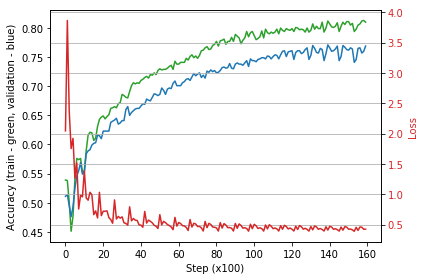

In [18]:
fig, ax1 = plt.subplots()

color_tr = 'tab:green'
color_val = 'tab:blue'
ax1.set_xlabel("Step (x100)")
ax1.set_ylabel("Accuracy (train - green, validation - blue)")
ax1.plot(range(len(accuracy_train)), accuracy_train, color=color_tr)
ax1.plot(range(len(accuracy_test)), accuracy_test, color=color_val)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color_loss = 'tab:red'
ax2.set_ylabel("Loss", color=color_loss)  # we already handled the x-label with ax1
ax2.plot(range(len(losses)), losses, color=color_loss)
ax2.tick_params(axis='y', labelcolor=color_loss)

fig.tight_layout()
plt.grid()
plt.show()

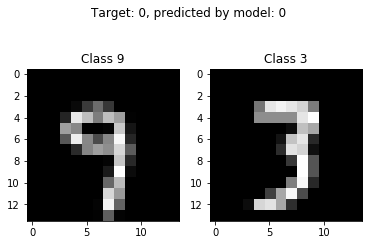

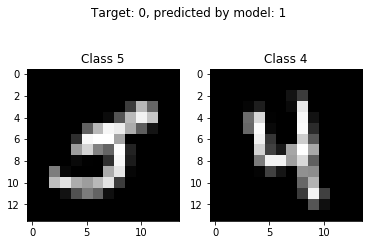

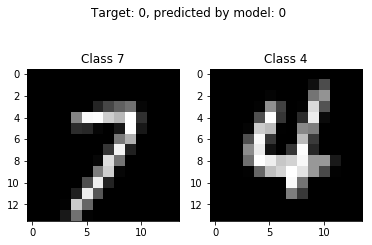

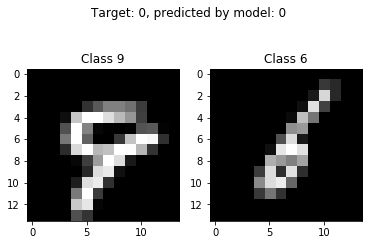

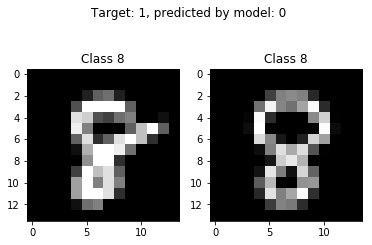

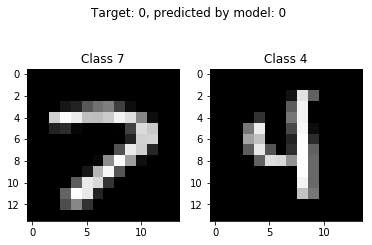

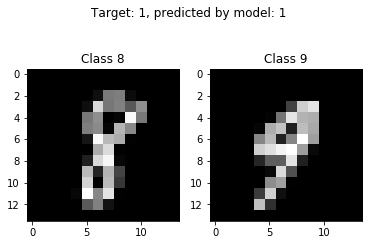

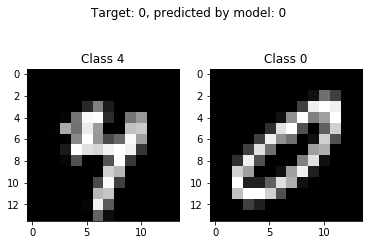

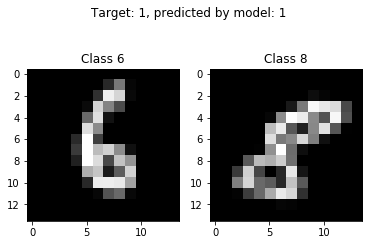

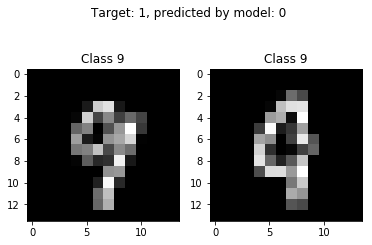

In [19]:
for ind in range(10):
    image = train_input[ind]
    target = train_target[ind]
    classes = train_classes[ind]
    
    predicted = net.predict(image.unsqueeze(0))
    
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(image[0], cmap="gray")
    axs[0].set_title(f"Class {classes[0].item()}")
    axs[1].imshow(image[1], cmap="gray")
    axs[1].set_title(f"Class {classes[1].item()}")
    fig.suptitle(f"Target: {target.item()}, predicted by model: {predicted.item()}")

    plt.show()

## Experiments

All the experiments should be done with 1, 000 pairs for training and test. A convnet with ∼ 70, 000
parameters can be trained with 25 epochs in the VM in less than 2s and should achieve ∼ 15% error
rate.

Performance estimates provided in your report should be estimated through 10+ rounds for each
architecture, where both data and weight initialization are randomized, and you should provide estimates
of standard deviations.